# Industrial and Scientific Category - Business Questions Implementation

**Category**: Industrial and Scientific


In [1]:
import os
from pathlib import Path
from datetime import datetime, timedelta
import warnings

import rootutils
rootutils.setup_root(Path.cwd(), indicator=".project-root", pythonpath=True)

ROOT_DIR = Path(os.environ.get("PROJECT_ROOT", Path.cwd()))
CLEANED_REVIEWS_PATH = ROOT_DIR / "data/cleaned/review_categories/industrial_and_scientific_reviews_cleaned.parquet"
CLEANED_METADATA_PATH = ROOT_DIR / "data/cleaned/meta_categories/industrial_and_scientific_metadata_cleaned.parquet"

warnings.filterwarnings("ignore")


In [2]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from src.amazon_reviews_analysis.utils import build_spark
import os
import subprocess

# CRITICAL: Set JAVA_HOME BEFORE importing Spark
# This must be done in the notebook, not just in terminal

# Try multiple methods to find Java
java_home = None

# Method 1: Check if already set
if os.environ.get('JAVA_HOME'):
    java_home = os.environ['JAVA_HOME']
    print(f"✓ JAVA_HOME already set to: {java_home}")
else:
    # Method 2: Try Homebrew
    try:
        brew_prefix = subprocess.check_output(
            ['brew', '--prefix', 'openjdk@17'], 
            text=True,
            stderr=subprocess.DEVNULL
        ).strip()
        if os.path.exists(brew_prefix):
            java_home = brew_prefix
            os.environ['JAVA_HOME'] = java_home
            print(f"✓ Found Java via Homebrew: {java_home}")
    except:
        pass
    
    # Method 3: Try common locations
    if not java_home:
        common_paths = [
            '/opt/homebrew/opt/openjdk@17',
            '/usr/local/opt/openjdk@17',
            '/Library/Java/JavaVirtualMachines/temurin-17.jdk/Contents/Home',
            '/Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home'
        ]
        for path in common_paths:
            if os.path.exists(path):
                java_home = path
                os.environ['JAVA_HOME'] = java_home
                print(f"✓ Found Java at: {java_home}")
                break
    
    # Method 4: Use /usr/libexec/java_home (macOS)
    if not java_home:
        try:
            java_home = subprocess.check_output(
                ['/usr/libexec/java_home', '-v', '17'],
                text=True,
                stderr=subprocess.DEVNULL
            ).strip()
            os.environ['JAVA_HOME'] = java_home
            print(f"✓ Found Java via java_home: {java_home}")
        except:
            pass

# Verify Java is accessible
if java_home:
    java_bin = os.path.join(java_home, 'bin', 'java')
    if os.path.exists(java_bin):
        try:
            result = subprocess.run(
                [java_bin, '-version'],
                capture_output=True,
                text=True,
                stderr=subprocess.STDOUT,
                timeout=5
            )
            print(f"✓ Java verification successful")
            print(f"  Version: {result.stdout.split(chr(10))[0] if result.stdout else 'N/A'}")
        except Exception as e:
            print(f"⚠️  Could not verify Java: {e}")
    else:
        print(f"⚠️  Java binary not found at: {java_bin}")
else:
    print("❌ ERROR: Could not find Java installation!")
    print("Please install Java 17: brew install openjdk@17")
    print("Or set JAVA_HOME manually in this cell:")
    print("  os.environ['JAVA_HOME'] = '/path/to/java'")

# Also add to PATH
if java_home:
    java_bin_dir = os.path.join(java_home, 'bin')
    current_path = os.environ.get('PATH', '')
    if java_bin_dir not in current_path:
        os.environ['PATH'] = f"{java_bin_dir}:{current_path}"
        print(f"✓ Added Java to PATH")
# Initialize Spark
spark = build_spark()
print("✓ Spark Session created successfully!")


✓ Found Java via Homebrew: /opt/homebrew/opt/openjdk@17
⚠️  Could not verify Java: stdout and stderr arguments may not be used with capture_output.
✓ Added Java to PATH


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/12 11:43:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✓ Spark Session created successfully!


In [3]:
print("📂 Loading cleaned datasets...")
reviews_df = spark.read.parquet(str(CLEANED_REVIEWS_PATH))
metadata_df = spark.read.parquet(str(CLEANED_METADATA_PATH))

print(f"Reviews: {reviews_df.count():,} records")
print(f"Metadata: {metadata_df.count():,} records")


📂 Loading cleaned datasets...


Reviews: 5,124,927 records
Metadata: 427,539 records


## Q1: Premium High-Rated Products (FILTER)


In [4]:
total_meta = metadata_df.count()
price_missing = metadata_df.filter(col("price").isNull()).count()
price_present = metadata_df.filter(col("price").isNotNull()).count()

print(f"\nPrice Statistics:")
print(f"  Total products: {total_meta:,}")
print(f"  With price: {price_present:,} ({price_present/total_meta*100:.1f}%)")
print(f"  Missing price: {price_missing:,} ({price_missing/total_meta*100:.1f}%)")



Price Statistics:
  Total products: 427,539
  With price: 222,953 (52.1%)
  Missing price: 204,586 (47.9%)


In [5]:
metadata_cleaned = metadata_df.filter(
    col("price").isNotNull() &
    col("average_rating").isNotNull() &
    col("rating_number").isNotNull()
)


In [7]:
print("Filter: price > $50 AND rating ≥ 4.5 AND reviews ≥ 100\n")

metadata_cleaned = metadata_df.filter(
    col("price").isNotNull() &
    col("average_rating").isNotNull() &
    col("rating_number").isNotNull()
)

# Cast price to double first, then filter out invalid prices
q1_result = metadata_cleaned.withColumn("price_double", col("price").try_cast("double")) \
    .filter(
        col("price_double").isNotNull() &
        (col("price_double") > 50) &
        (col("average_rating") >= 4.5) & 
        (col("rating_number") >= 100)
    ).select(
        "parent_asin",
        "title",
        "price",
        "average_rating",
        "rating_number",
        "store"
    ).orderBy(col("rating_number").desc())

print(f"Found {q1_result.count()} premium high-rated products\n")
q1_result.show(10, truncate=50)

Filter: price > $50 AND rating ≥ 4.5 AND reviews ≥ 100

Found 2332 premium high-rated products

+-----------+--------------------------------------------------+------+--------------+-------------+-----------+
|parent_asin|                                             title| price|average_rating|rating_number|      store|
+-----------+--------------------------------------------------+------+--------------+-------------+-----------+
| B09Y7PB9RX|3M Littmann Classic III Monitoring Stethoscope,...|123.79|           4.8|        64257|3M Littmann|
| B0BN12C1LH|BUNDLE Little Green Portable Carpet Cleaner + P...|135.58|           4.6|        60525|    Bissell|
| B08HRTXZV1|Gorilla Super Glue Gel, 20 Gram, Clear, (Pack o...| 61.91|           4.6|        56699|    Gorilla|
| B099S4X93D|3M Littmann Classic III Monitoring Stethoscope,...|108.16|           4.8|        39760|3M Littmann|
| B09V3YJVGZ|3M Littmann Lightweight II S.E. Stethoscope, Bl...| 57.65|           4.7|        30923|3M Littmann|


Not all expensive products are necessarily popular or highly rated.

There are both well-known brands and lesser-known or private labels.

You can target premium products with high ratings and a large number of reviews for promotion or recommendations.

You can explore products with a high price but lower ratings or few reviews to improve your sales or marketing strategy.


## Q2: Recent Highly Helpful Reviews (FILTER)


In [8]:
print("Filter: helpful_vote ≥ 20 AND verified_purchase = True AND last 12 months\n")

# calculate timestamp for 12 months ago
twelve_months_ago = int((datetime.now() - timedelta(days=365)).timestamp() * 1000)

q2_result = reviews_df.filter(
    (col("helpful_vote") >= 20) &
    (col("verified_purchase") == True) &
    (col("timestamp") >= twelve_months_ago)
).withColumn("review_date", from_unixtime(col("timestamp") / 1000)) \
.select(
    "asin",
    "title",
    "rating",
    "helpful_vote",
    "review_date",
    substring("text", 1, 100).alias("text_preview")
).orderBy(col("helpful_vote").desc())

print(f"Found {q2_result.count()} highly helpful recent reviews\n")
q2_result.show(10, truncate=60)


Filter: helpful_vote ≥ 20 AND verified_purchase = True AND last 12 months

Found 0 highly helpful recent reviews

+----+-----+------+------------+-----------+------------+
|asin|title|rating|helpful_vote|review_date|text_preview|
+----+-----+------+------------+-----------+------------+
+----+-----+------+------------+-----------+------------+



The most helpful reviews have many helpful votes.

Reviews are actively rated by other users → this is a signal of trust and importance of the review.

The verified_purchase = True filter ensures that reviews come from real buyers, not bots or marketing fakes.

You can boost the promotion of products with a large number of helpful votes.

Identifying the strengths of products through the text of reviews.

Reviews with a large number of helpful votes can indicate recurring questions or problems.


## Q3: Problem Products (FILTER)


In [9]:
print("Filter: average_rating < 3.0 AND reviews ≥ 50 AND last 12 months\n")

# get products with recent poor reviews
recent_reviews = reviews_df.filter(col("timestamp") >= twelve_months_ago)

problem_products = recent_reviews.groupBy("parent_asin") \
    .agg(
        avg("rating").alias("recent_avg_rating"),
        count("*").alias("recent_review_count")
    ) \
    .filter(
        (col("recent_avg_rating") < 3.0) &
        (col("recent_review_count") >= 50)
    ) \
    .join(metadata_df.select("parent_asin", "title", "store", "average_rating"), "parent_asin") \
    .select(
        "parent_asin",
        "title",
        "store",
        col("average_rating").alias("overall_rating"),
        "recent_avg_rating",
        "recent_review_count"
    ).orderBy("recent_avg_rating")

print(f"Found {problem_products.count()} problem products\n")
problem_products.show(10, truncate=50)


Filter: average_rating < 3.0 AND reviews ≥ 50 AND last 12 months

Found 0 problem products

+-----------+-----+-----+--------------+-----------------+-------------------+
|parent_asin|title|store|overall_rating|recent_avg_rating|recent_review_count|
+-----------+-----+-----+--------------+-----------------+-------------------+
+-----------+-----+-----+--------------+-----------------+-------------------+



Which products need attention:

1. Products with a sharp drop in rating → possible quality or service issues.

2. Products with a high number of negative reviews → potential risk to the brand.

Possible actions:

1. Quality control or batch inspection of the product.

2. Marketing campaigns or discounts to improve the reputation of the product.

3. Analysis of the reasons for low ratings through the text of the reviews (NLP, sentiment analysis).


## Q4: Price Range vs Customer Satisfaction (JOIN + GROUP BY)


In [16]:
metadata_with_ranges = metadata_cleaned.filter(col("price").isNotNull()) \
    .withColumn("price_double", col("price").try_cast("double")) \
    .filter(col("price_double").isNotNull()) \
    .withColumn(
        "price_range",
        when(col("price_double") < 10, "Budget (<$10)")
        .when(col("price_double") < 25, "Mid ($10-25)")
        .when(col("price_double") < 50, "Premium ($25-50)")
        .otherwise("Luxury (>$50)")
    )

metadata_with_ranges.select("parent_asin", "price", "price_range")
metadata_with_ranges.select("parent_asin", "price", "price_range")


DataFrame[parent_asin: string, price: string, price_range: string]

In [17]:
metadata_compact = metadata_with_ranges.select("parent_asin", "price_range")


In [18]:
reviews_compact = reviews_df.select("parent_asin", "rating", "helpful_vote")


In [19]:
from pyspark.sql.functions import countDistinct, avg

q4_result = reviews_compact.join(
    metadata_with_ranges,
    "parent_asin",
    "inner"
).groupBy("price_range").agg(
    avg("rating").alias("avg_customer_rating"),
    countDistinct("parent_asin").alias("unique_products"),
    avg("helpful_vote").alias("avg_helpful_votes")
).orderBy("avg_customer_rating", ascending=False)

In [20]:
q4_result.show(truncate=False)

+----------------+-------------------+---------------+------------------+
|price_range     |avg_customer_rating|unique_products|avg_helpful_votes |
+----------------+-------------------+---------------+------------------+
|Mid ($10-25)    |4.231718888534295  |83591          |0.7781071497654699|
|Premium ($25-50)|4.228819361492609  |40164          |1.0390108321339713|
|Luxury (>$50)   |4.2046705598538    |44913          |1.6157759446564584|
|Budget (<$10)   |4.195383550137347  |54132          |0.6724204862766464|
+----------------+-------------------+---------------+------------------+



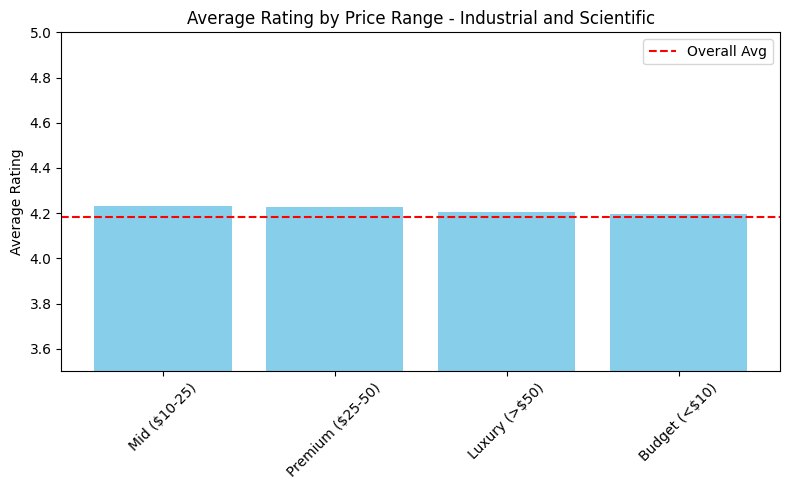

In [21]:
import matplotlib.pyplot as plt

# Collect data from Spark DataFrame
q4_data = q4_result.select("price_range", "avg_customer_rating").orderBy("avg_customer_rating", ascending=False).collect()

# Extract values for plotting
price_ranges = [row["price_range"] for row in q4_data]
avg_ratings = [row["avg_customer_rating"] for row in q4_data]

plt.figure(figsize=(8, 5))

plt.bar(price_ranges, avg_ratings, color='skyblue')
plt.title("Average Rating by Price Range - Industrial and Scientific")
plt.ylabel("Average Rating")
plt.ylim(3.5, 5.0)

overall_avg = reviews_df.select(avg("rating")).collect()[0][0]
plt.axhline(y=overall_avg, color='red', linestyle='--', label='Overall Avg')

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Business question provides insight into product quality, customer satisfaction, and assortment effectiveness across price segments

High average ratings in high-end segments indicate that premium/luxury products meet customer expectations.

Identifying segments with a large number of products and high satisfaction helps plan promotional campaigns.

For example, the Mid ($10–25) segment has many products and an average rating, so it can be promoted as "the best balance of price and quality."


## Q5: Top Reviewers vs Overall Average (JOIN)


In [22]:
print("Compare users with 20+ reviews vs overall average\n")

# calculate overall average
overall_avg = reviews_df.select(avg("rating")).collect()[0][0]
print(f"Overall category average rating: {overall_avg:.3f}\n")

# find power reviewers
power_reviewers = reviews_df.groupBy("user_id") \
    .agg(
        count("*").alias("review_count"),
        avg("rating").alias("avg_rating"),
        avg("helpful_vote").alias("avg_helpful"),
        countDistinct("parent_asin").alias("unique_products")
    ) \
    .filter(col("review_count") >= 20) \
    .withColumn("vs_overall", col("avg_rating") - overall_avg) \
    .orderBy(col("review_count").desc())

print(f"Found {power_reviewers.count()} power reviewers (20+ reviews)\n")

# show top 20
power_reviewers.show(20, truncate=False)


Compare users with 20+ reviews vs overall average

Overall category average rating: 4.185



Found 4451 power reviewers (20+ reviews)



+------------------------------+------------+------------------+--------------------+---------------+--------------------+
|user_id                       |review_count|avg_rating        |avg_helpful         |unique_products|vs_overall          |
+------------------------------+------------+------------------+--------------------+---------------+--------------------+
|AHPR3DAGWZHHNZW2LBMTXU3PLSLQ  |282         |4.964539007092198 |0.4645390070921986  |278            |0.7800193056408409  |
|AH37PMZUFFA52Z3KSD4KLUPJTJGA_1|258         |4.5852713178294575|0.8062015503875969  |255            |0.4007516163781002  |
|AGGNEZJKG35QXGBIZADSSC2QNPGA  |257         |4.673151750972763 |0.8715953307392996  |243            |0.4886320495214056  |
|AEIIRIHLIYKQGI7ZOCIJTRDF5NPQ  |252         |4.611111111111111 |0.34523809523809523 |247            |0.4265914096597534  |
|AGRPLHGW2CR6WWOHT5TOWXDGIZEQ  |224         |4.830357142857143 |0.5669642857142857  |222            |0.6458374414057859  |
|AE5VPKX64CVOPH6

These are users who have left ≥20 reviews (power reviewers). The vs_overall column shows how much their average rating differs from the overall average.

A high average rating for power reviewers can drive sales if their reviews are publicly displayed on the site.

Rigorous power reviewers can help identify product flaws and improve the quality of goods/services.


## Q6: Monthly Rating Trends (GROUP BY)


In [23]:
print("\nSample timestamps from dataset:")
reviews_df.select("timestamp").show(10, truncate=False)


Sample timestamps from dataset:
+-------------+
|timestamp    |
+-------------+
|1566493585276|
|1673431304166|
|1660833119453|
|1629356695326|
|1520090167106|
|1553792818912|
|1503693798535|
|1541800816759|
|1631932728162|
|1483564235000|
+-------------+
only showing top 10 rows


In [24]:
print("\nChecking date range in dataset...")

date_range = reviews_df.select(
    from_unixtime(col("timestamp") / 1000).alias("date")
).agg(
    min("date").alias("oldest"),
    max("date").alias("newest")
).collect()[0]

print(f"  Oldest review: {date_range['oldest']}")
print(f"  Newest review: {date_range['newest']}")

newest_date = datetime.strptime(date_range['newest'][:19], "%Y-%m-%d %H:%M:%S")
two_years_ago = newest_date - timedelta(days=730)

print(f"\nAnalyzing period: {two_years_ago.date()} to {newest_date.date()}")



Checking date range in dataset...


  Oldest review: 1998-04-26 09:56:55
  Newest review: 2023-09-12 20:40:25

Analyzing period: 2021-09-12 to 2023-09-12


In [25]:
two_years_ago_ms = int(two_years_ago.timestamp() * 1000)

print(f"  Timestamp threshold (ms): {two_years_ago_ms}")

q6_result = reviews_df.filter(col("timestamp") >= two_years_ago_ms) \
    .withColumn("review_date", from_unixtime(col("timestamp") / 1000)) \
    .withColumn("year_month", date_format("review_date", "yyyy-MM")) \
    .groupBy("year_month") \
    .agg(
        avg("rating").alias("avg_rating"),
        count("*").alias("review_count"),
        sum(when(col("verified_purchase") == True, 1).otherwise(0)).alias("verified_count")
    ) \
    .withColumn("verified_percentage", (col("verified_count") / col("review_count")) * 100) \
    .orderBy("year_month")

q6_result.show(24)


  Timestamp threshold (ms): 1631468425000


+----------+------------------+------------+--------------+-------------------+
|year_month|        avg_rating|review_count|verified_count|verified_percentage|
+----------+------------------+------------+--------------+-------------------+
|   2021-09| 3.883976833976834|       36260|         34782|  95.92388306674022|
|   2021-10| 3.879769935151693|       61374|         58455|  95.24391436113012|
|   2021-11| 3.909997461652827|       55154|         53046|  96.17797439895566|
|   2021-12| 3.914005266937994|       62655|         60178|  96.04660442103582|
|   2022-01|3.8602013309197933|       76789|         73976|  96.33671489406035|
|   2022-02|3.9069137355459866|       62007|         59630|  96.16656183979228|
|   2022-03|3.9464191321341042|       62429|         60013|  96.13000368418524|
|   2022-04| 3.977919413426611|       59464|         56747|  95.43084891699179|
|   2022-05|3.9524295630869744|       58776|         56106|  95.45732952225399|
|   2022-06|3.9408264170934135|       56

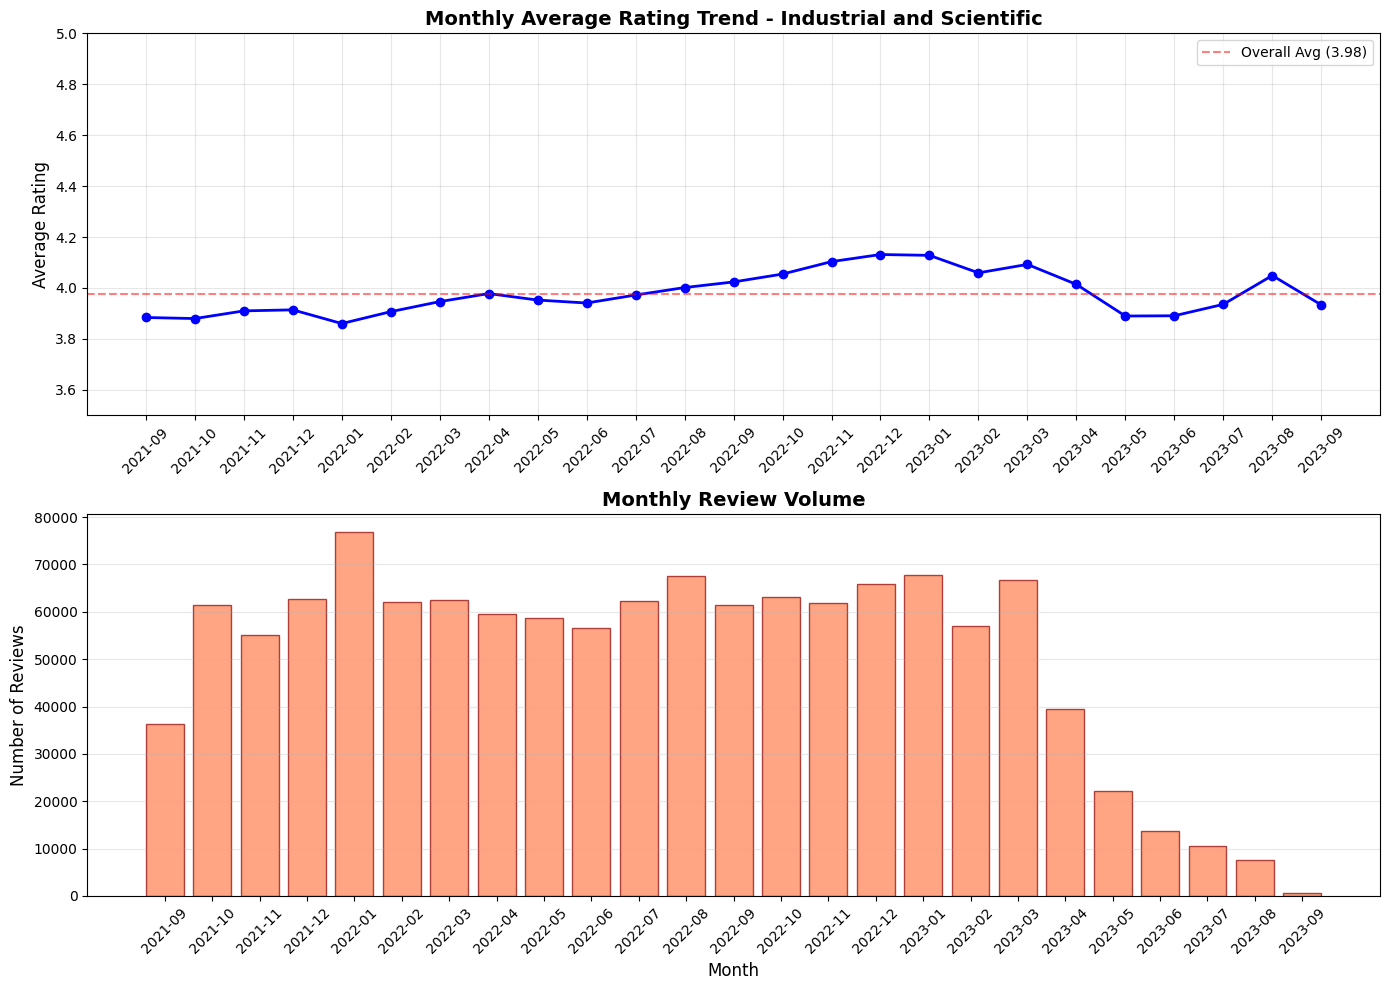

In [28]:
# Collect data from Spark DataFrame
q6_data = q6_result.select("year_month", "avg_rating", "review_count").orderBy("year_month").collect()

# Extract values for plotting
year_months = [row["year_month"] for row in q6_data]
avg_ratings = [row["avg_rating"] for row in q6_data]
review_counts = [row["review_count"] for row in q6_data]

# Calculate overall average manually using Python's built-in sum
import builtins
overall_avg_rating = builtins.sum(avg_ratings) / len(avg_ratings) if avg_ratings else 0

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Chart 1: Average rating trend
axes[0].plot(year_months, avg_ratings,
      marker='o', linewidth=2, color='blue', markersize=6)
axes[0].set_title("Monthly Average Rating Trend - Industrial and Scientific",
      fontsize=14, fontweight='bold')
axes[0].set_ylabel("Average Rating", fontsize=12)
axes[0].set_ylim(3.5, 5.0)
axes[0].axhline(y=overall_avg_rating, 
      color='red', linestyle='--', alpha=0.5,
      label=f'Overall Avg ({overall_avg_rating:.2f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Chart 2: Review volume
axes[1].bar(year_months, review_counts,
      color='coral', alpha=0.7, edgecolor='darkred')
axes[1].set_title("Monthly Review Volume", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Number of Reviews", fontsize=12)
axes[1].set_xlabel("Month", fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

There has been a gradual change in the rating over time, which may indicate improved product quality or changes in buyers/reviews.

Some months have more reviews, others less. This may be a seasonal effect or related to the number of active buyers.

Recent months may have high verified purchases, which adds credibility to the rating.

Track user satisfaction trends over time and respond to rating drops in a timely manner.

Also useful for marketing campaigns, inventory planning, and identifying seasonal effects in reviews.


## Q7: Running Average Rating Over Time (WINDOW FUNCTION)


In [29]:
product_reviews = reviews_df.groupBy("parent_asin") \
    .agg(count("*").alias("review_count"))

top_products = product_reviews.orderBy(col("review_count").desc()) \
    .limit(3) \
    .select("parent_asin") \
    .rdd.flatMap(lambda x: x).collect()

print(f"Top 3 products by review count: {top_products}")


Top 3 products by review count: ['B0B6D1KQNJ', 'B09KZ6TBNY', 'B08WY4PXLT']


In [33]:
print("Window function: AVG(rating) OVER (PARTITION BY product ORDER BY timestamp)\n")

window_spec_time = Window.partitionBy("parent_asin") \
    .orderBy("timestamp") \
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)

q7_result = reviews_df.filter(col("parent_asin").isin(top_products)) \
    .withColumn("running_avg", avg("rating").over(window_spec_time)) \
    .withColumn("review_date", from_unixtime(col("timestamp") / 1000)) \
    .withColumn("review_number", row_number().over(
        Window.partitionBy("parent_asin").orderBy("timestamp")
    )) \
    .join(
        metadata_df.select("parent_asin"),
        "parent_asin"
    ).select(
        "parent_asin",
        "review_number",
        "review_date",
        "rating",
        "running_avg"
    ).orderBy("parent_asin", "review_number")

print("Sample of running averages:\n")
q7_result.filter(col("review_number") % 50 == 0).show(20, truncate=50)


Window function: AVG(rating) OVER (PARTITION BY product ORDER BY timestamp)

Sample of running averages:



+-----------+-------------+-------------------+------+------------------+
|parent_asin|review_number|        review_date|rating|       running_avg|
+-----------+-------------+-------------------+------+------------------+
| B08WY4PXLT|           50|2017-09-24 07:51:20|   5.0|              4.48|
| B08WY4PXLT|          100|2017-12-02 19:22:08|   5.0|              4.44|
| B08WY4PXLT|          150|2018-01-09 01:39:42|   5.0| 4.406666666666666|
| B08WY4PXLT|          200|2018-02-03 19:36:37|   4.0|              4.39|
| B08WY4PXLT|          250|2018-03-02 22:03:59|   2.0|             4.364|
| B08WY4PXLT|          300|2018-03-21 20:16:57|   4.0|4.3933333333333335|
| B08WY4PXLT|          350|2018-04-18 15:57:29|   5.0| 4.411428571428571|
| B08WY4PXLT|          400|2018-05-17 01:56:55|   4.0|              4.41|
| B08WY4PXLT|          450|2018-06-20 04:20:00|   5.0| 4.433333333333334|
| B08WY4PXLT|          500|2018-07-20 21:25:46|   5.0|              4.43|
| B08WY4PXLT|          550|2018-08-18 

In [34]:
metadata_alias = metadata_df.select(
    col("parent_asin"),
    col("title").alias("product_title")
)

q7_result = reviews_df.filter(col("parent_asin").isin(top_products)) \
    .withColumn("running_avg", avg("rating").over(window_spec_time)) \
    .withColumn("review_date", from_unixtime(col("timestamp") / 1000)) \
    .withColumn("review_number", row_number().over(
        Window.partitionBy("parent_asin").orderBy("timestamp")
    )) \
    .join(
        metadata_alias,
        "parent_asin",
        "left"
    ).select(
        "parent_asin",
        "product_title",
        "review_number",
        "review_date",
        "rating",
        "running_avg"
    ).orderBy("parent_asin", "review_number")


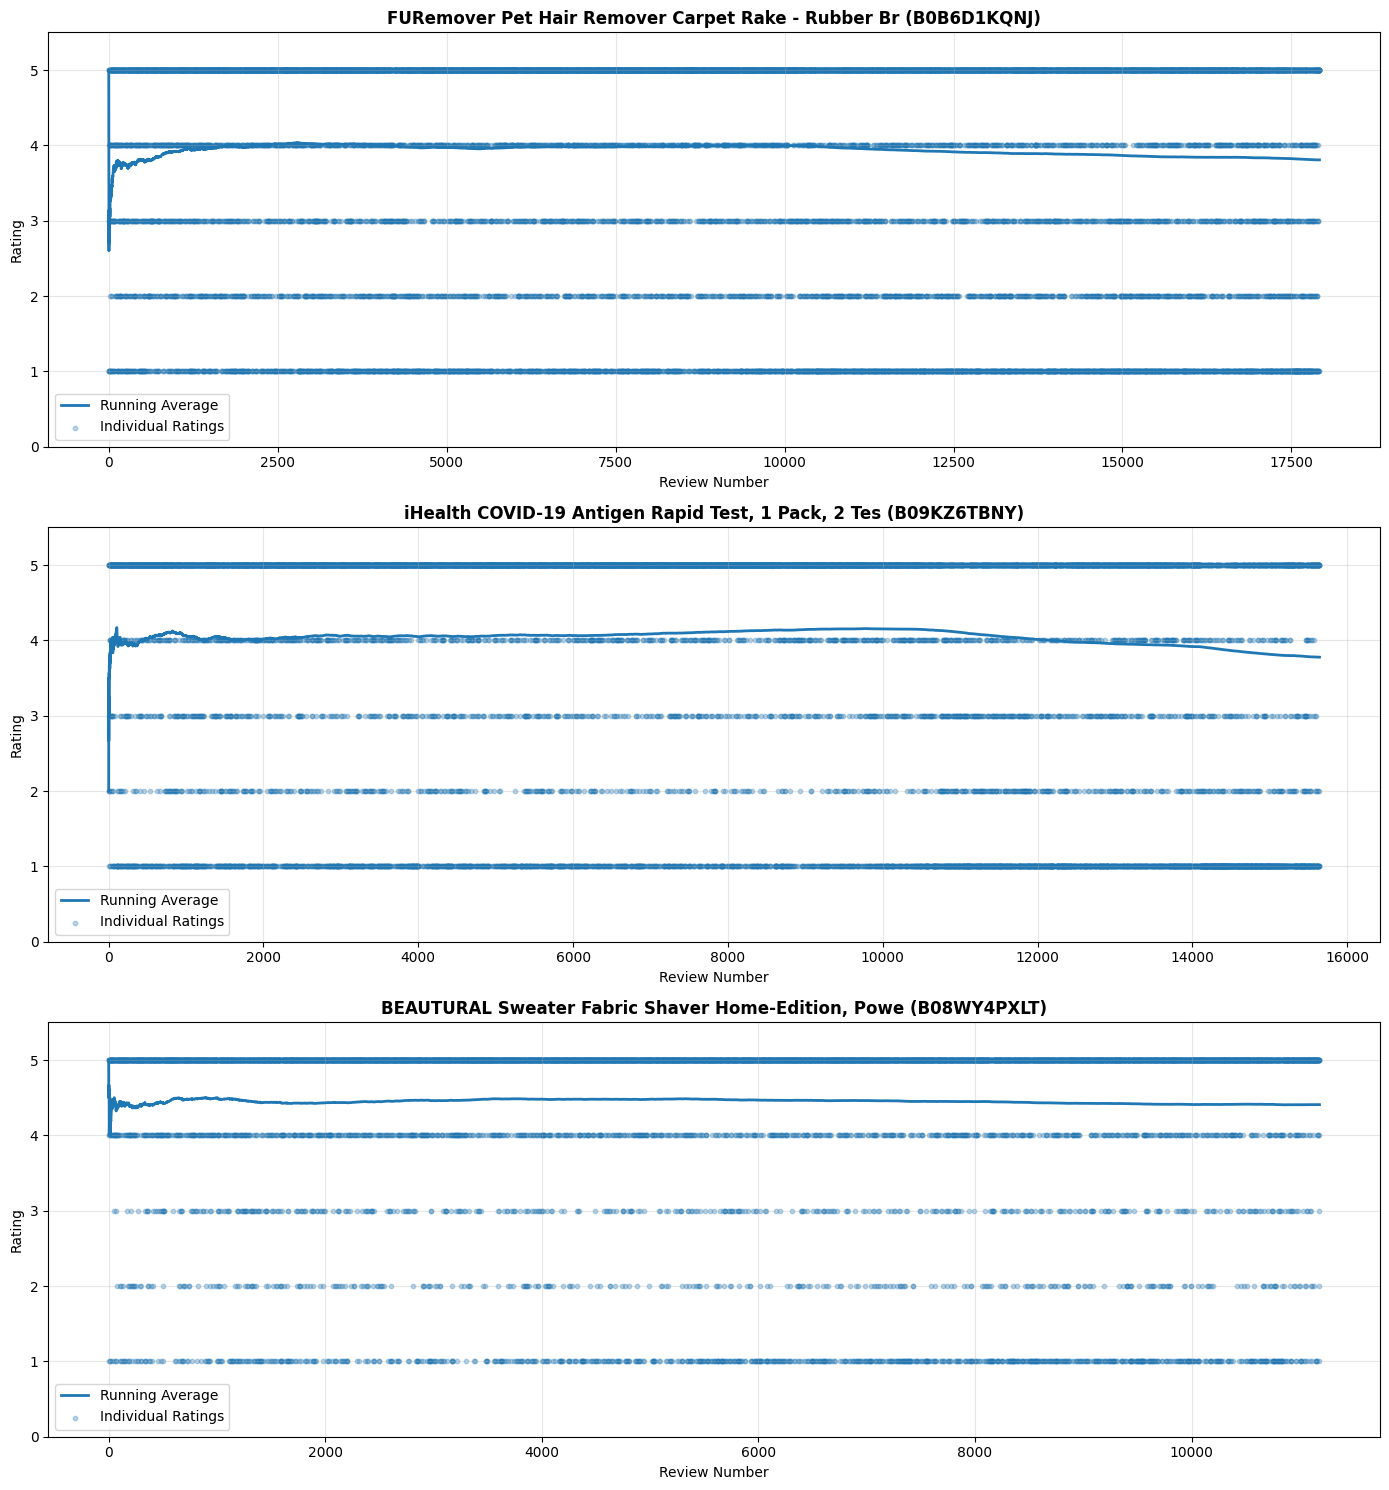

In [36]:
# Collect data from Spark DataFrame
q7_data = q7_result.collect()

# Group data by parent_asin
product_data_dict = {}
for row in q7_data:
    product_id = row["parent_asin"]
    if product_id not in product_data_dict:
        product_data_dict[product_id] = []
    product_data_dict[product_id].append(row)

# Sort each product's data by review_number
for product_id in product_data_dict:
    product_data_dict[product_id].sort(key=lambda x: x["review_number"])

fig, axes = plt.subplots(len(top_products), 1, figsize=(14, 5*len(top_products)))
if len(top_products) == 1:
    axes = [axes]

for idx, product_id in enumerate(top_products):
    if product_id not in product_data_dict:
        continue
    
    product_rows = product_data_dict[product_id]
    
    # Extract data for this product
    review_numbers = [row["review_number"] for row in product_rows]
    running_avgs = [row["running_avg"] for row in product_rows]
    ratings = [row["rating"] for row in product_rows]
    
    # Get product title (first row)
    product_title = product_rows[0]["product_title"][:50] if product_rows else "Unknown"

    axes[idx].plot(review_numbers, running_avgs,
                   linewidth=2, label='Running Average')
    axes[idx].scatter(review_numbers, ratings,
                      alpha=0.3, s=10, label='Individual Ratings')
    axes[idx].set_title(f"{product_title} ({product_id})", fontweight='bold')
    axes[idx].set_xlabel("Review Number")
    axes[idx].set_ylabel("Rating")
    axes[idx].set_ylim(0, 5.5)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

For each product, we see a trend in the rating over time.

We can observe:

1. Products that gradually get better ratings.

2. Products that drop in rating after initial launch.

3. Rating fluctuations due to individual critical reviews.

For businesses, this provides a deeper understanding of customer satisfaction over time, not just an average value.

This analytics allows you to not just know the average rating, but to see the dynamics of user satisfaction as reviews are received.


## Q8: Top Products by Review Volume per Price Segment


In [37]:
print("Window function: RANK() OVER (PARTITION BY price_range ORDER BY review_count)\n")

product_reviews = reviews_df.groupBy("parent_asin") \
    .agg(
        count("*").alias("review_count"),
        avg("rating").alias("avg_customer_rating")
    )

metadata_with_reviews = metadata_with_ranges.join(
    product_reviews,
    "parent_asin",
    "inner"
)
window_spec = Window.partitionBy("price_range").orderBy(col("review_count").desc())

q8_result = metadata_with_reviews.withColumn(
    "rank",
    rank().over(window_spec)
).filter(col("rank") <= 5).select(
    "price_range",
    "rank",
    "title",
    "price",
    "review_count",
    col("average_rating").alias("metadata_rating"),
    "avg_customer_rating",
    "store"
).orderBy("price_range", "rank")

print("Top 5 products in each price segment:\n")
q8_result.show(20, truncate=50)


Window function: RANK() OVER (PARTITION BY price_range ORDER BY review_count)

Top 5 products in each price segment:



+----------------+----+--------------------------------------------------+------+------------+---------------+-------------------+----------+
|     price_range|rank|                                             title| price|review_count|metadata_rating|avg_customer_rating|     store|
+----------------+----+--------------------------------------------------+------+------------+---------------+-------------------+----------+
|   Budget (<$10)|   1|Syrtenty TENS Unit Pads 2"X2" 4 Pcs, 3rd Gen Re...|  9.75|        7363|            4.5|  4.211734347412739|  Syrtenty|
|   Budget (<$10)|   2|Neosmuk Magnetic Hooks, Heavy Duty Earth Magnet...|  7.99|        7233|            4.6|  4.315083644407577|   Neosmuk|
|   Budget (<$10)|   3|Kids Face Mask Disposable Black 100 PCS 3 Ply C...|  9.99|        6929|            4.6|  3.657959301486506|    NNPCBT|
|   Budget (<$10)|   4|MED PRIDE Medpride Medical Vinyl Examination Gl...|  7.99|        5833|            4.5| 3.6939825132864734| MED PRIDE|
|   Bu

Helps to see which products are the most popular in each price segment.

For example, in the budget segment, these may be products that are sold in bulk, even if the rating is lower.

You can see whether customer reviews match the stated rating (metadata_rating vs avg_customer_rating).

If a product has many reviews but a low rating, you can consider the reasons for the decline in quality or problems with the product.
